In [1]:
import sys
import random; random.seed(90)
import numpy as np
from collections import defaultdict
from IPython.display import clear_output

from utils import plot_blackjack_values, plot_policy
from blackjack import BlackjackEnv

In [2]:
# init the environment
env = BlackjackEnv()

In [3]:
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Action space: Discrete(2)


## Play with a Random Policy

In [4]:
for i_episode in range(3):

    state = env.reset()
    print('-------------------')
    print(f'PLAY EPISODE {i_episode+1}')
    print('-------------------')
    while True:
        action = env.action_space.sample() # random policy
        next_state, reward, done, info = env.step(action)
        print('Player\'s card:', state[0])
        print('Dealer\'s card:', state[1])
        print('Any ace:', state[2])
        if action == 1: # 1 for draw and 0 for stick
            if next_state[0] > 21:
                print(f'Random action: {action} -> Next card: {next_state[0]} (Bust!)')
            else:
                print(f'Random action: {action} -> Next card: {next_state[0]}')
        else:
            print(f'Random action: {action}')
        state = next_state
        print('-------------------')
        if done:
            print('End game\'s reward:', reward)
            print('*You won :)\n') if reward > 0 else print('*You lost :(\n')
            break
            
print('*The reason of losts could be bust or dealer\'s sum card is more than player\'s own.')

-------------------
PLAY EPISODE 1
-------------------
Player's card: 14
Dealer's card: 10
Any ace: False
Random action: 0
-------------------
End game's reward: -1.0
*You lost :(

-------------------
PLAY EPISODE 2
-------------------
Player's card: 20
Dealer's card: 4
Any ace: False
Random action: 1 -> Next card: 22 (Bust!)
-------------------
End game's reward: -1
*You lost :(

-------------------
PLAY EPISODE 3
-------------------
Player's card: 11
Dealer's card: 3
Any ace: False
Random action: 1 -> Next card: 21
-------------------
Player's card: 21
Dealer's card: 3
Any ace: False
Random action: 0
-------------------
End game's reward: 0.0
*You lost :(

*The reason of losts could be bust or dealer's sum card is more than player's own.


## Set Utils

In [5]:
def run_game(env, policy):
    
    state = env.reset()
    episode = []
    finished = False
    
    while not finished:            
        timestep = []
        timestep.append(state)
        action = policy[state]
        
        state, reward, finished, info = env.step(action)
        timestep.append(action)
        timestep.append(reward)
        
        episode.append(timestep)
        
    return episode

In [6]:
def evaluate_policy(env, policy, num_episodes=100):
    wins = 0; loss = 0
    
    print('Now, the agent is playing...')
    for i in range(num_episodes):
        episode_reward = run_game(env, policy)[-1][-1]
        if episode_reward == 1:
            wins += 1
                
    return wins/ num_episodes

## Part 1: MC Prediction (Policy Evaluation)

In [7]:
def generate_episode_from_limit_stochastic(env):
    
    episode = []
    state = env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8] # state index 0 is for player
        action = np.random.choice(np.arange(2), p=probs) # 0 indicates STICK while 1 indicates HIT
        next_state, reward, done, info = env.step(action)
        state = next_state
        episode.append((state, action, reward))
        if done:
            break
    return episode

In [8]:
# this function will evaluate action value function
def mc_prediction_q(env, generate_episode, num_episodes, gamma=0.9):
    
    # init empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n)) # return sum is just the sum of all of the returns obtained over all episodes after visiting a particular state action pair
    N = defaultdict(lambda: np.zeros(env.action_space.n)) # total number of times the agent visit particular state action pair over all episodes
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # Q-table which contains the estimate for the actual values
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # generate an episode
        episode = generate_episode(env)
        
        # obtain the states, actions and rewards
        states, actions, rewards = zip(*episode)
        
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        # update the sum of the returns, number of visits, and action-values
        # this function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(discounts[:-(1+i)] * rewards[i:])
            N[state][actions[i]] += 1.0 # every-visit, in blackjack example, every-visit and first-visit MC predictions are equivalent
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [9]:
# obtain the action-value function
Q = mc_prediction_q(env, generate_episode_from_limit_stochastic, num_episodes=500000)

Episode 500000/500000.

In [10]:
# obtain the corresponding state-value function
V_to_plot = dict((k, (k[0]>18) * (np.dot([0.8, 0.2], v)) + (k[0]<=18) * (np.dot([0.2, 0.8], v))) \
                  for k, v in Q.items())

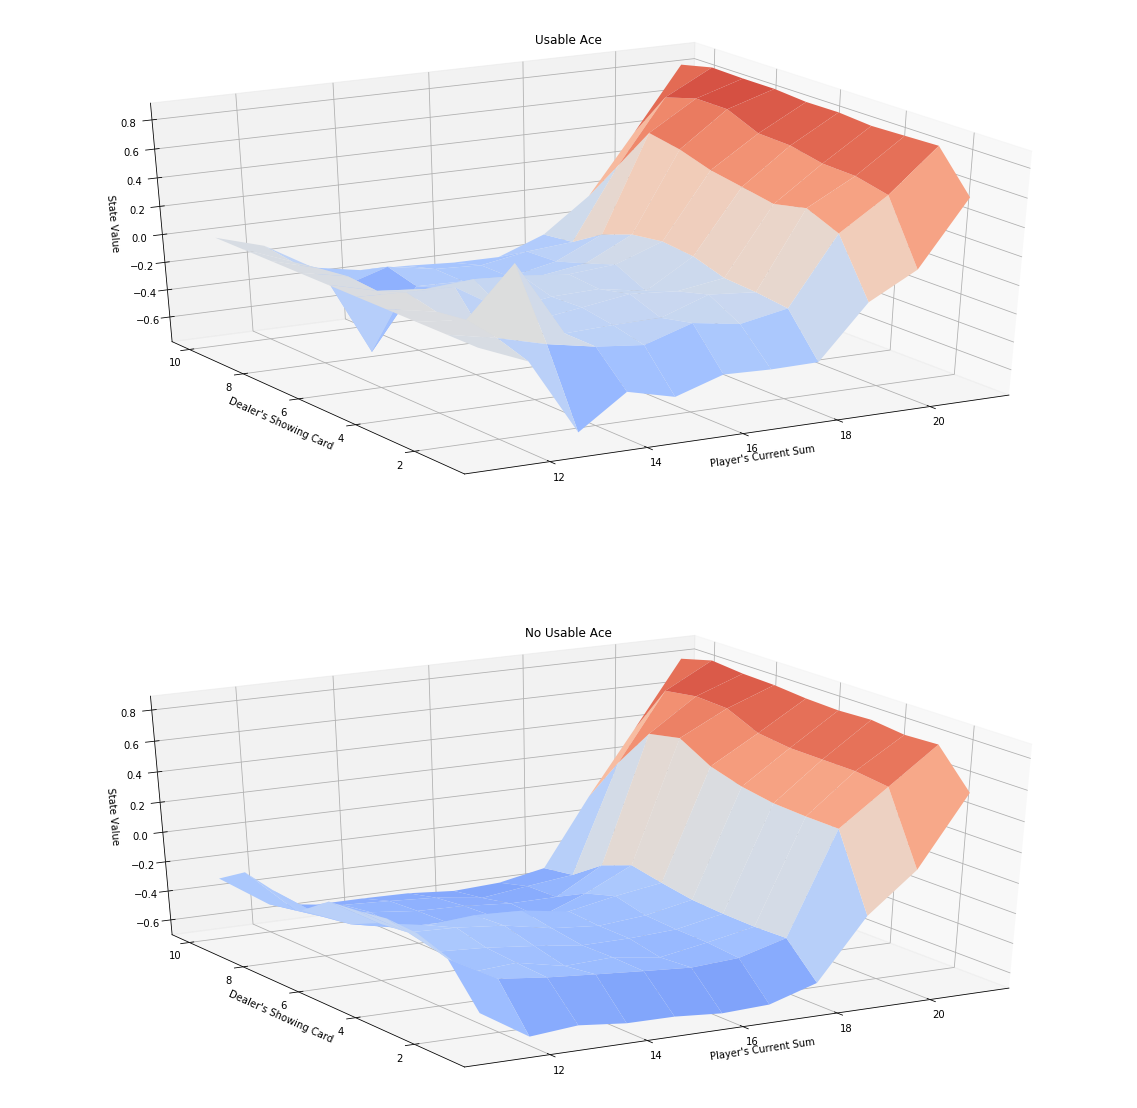

In [11]:
# plot the state-value function
plot_blackjack_values(V_to_plot)

## Part 2: MC Control (Policy Improvement)

In [12]:
def get_probability(Q_s, epsilon, nA):
    """Obtains the action probabilities corresponding to epsilon-greedy policy."""
    policy_state = np.ones(nA) * epsilon / nA # epsilon 0 is guaranteed to always select the greedy action
    best_action = np.argmax(Q_s)
    policy_state[best_action] = 1 - epsilon + (epsilon / nA)
    
    return policy_state

In [13]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """Generates an episode from following the epsilon-greedy policy.""" 
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probability(Q[state], epsilon, nA)) \
                                  if state in Q else env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [14]:
def update_Q(env, episode, Q, alpha, gamma):
    """Updates the action-value function estimate using the most recent episode."""
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        Q_temp = Q[state][actions[i]]
        # apply update equation for every state-action pair that appears in the episode 
        # this formula apply incremental mean concept using alpha denotation 
        # since using incremental mean, so the agent is able to to improve the policy after every episode!
        Q[state][actions[i]] = Q_temp + alpha*(sum(discounts[:-(1+i)] * rewards[i:]) - Q_temp)
    return Q

In [15]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    # This MC control algorithm implements every-visit MC
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # set the value of decayed-epsilon greedy aprroach
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        # alpha is close to zero so the action-value function estimate is not much updated by the agent
        Q = update_Q(env, episode, Q, alpha, gamma)
    
    # determine the policy corresponding to the final action-value function estimate
    # pick the action that maximizes the row corresponding to that state
    policy = dict((k, np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [16]:
# obtain the estimated optimal policy and action-value function
optimal_policy, Q = mc_control(env, num_episodes=500000, alpha=0.02)

Episode 500000/500000.

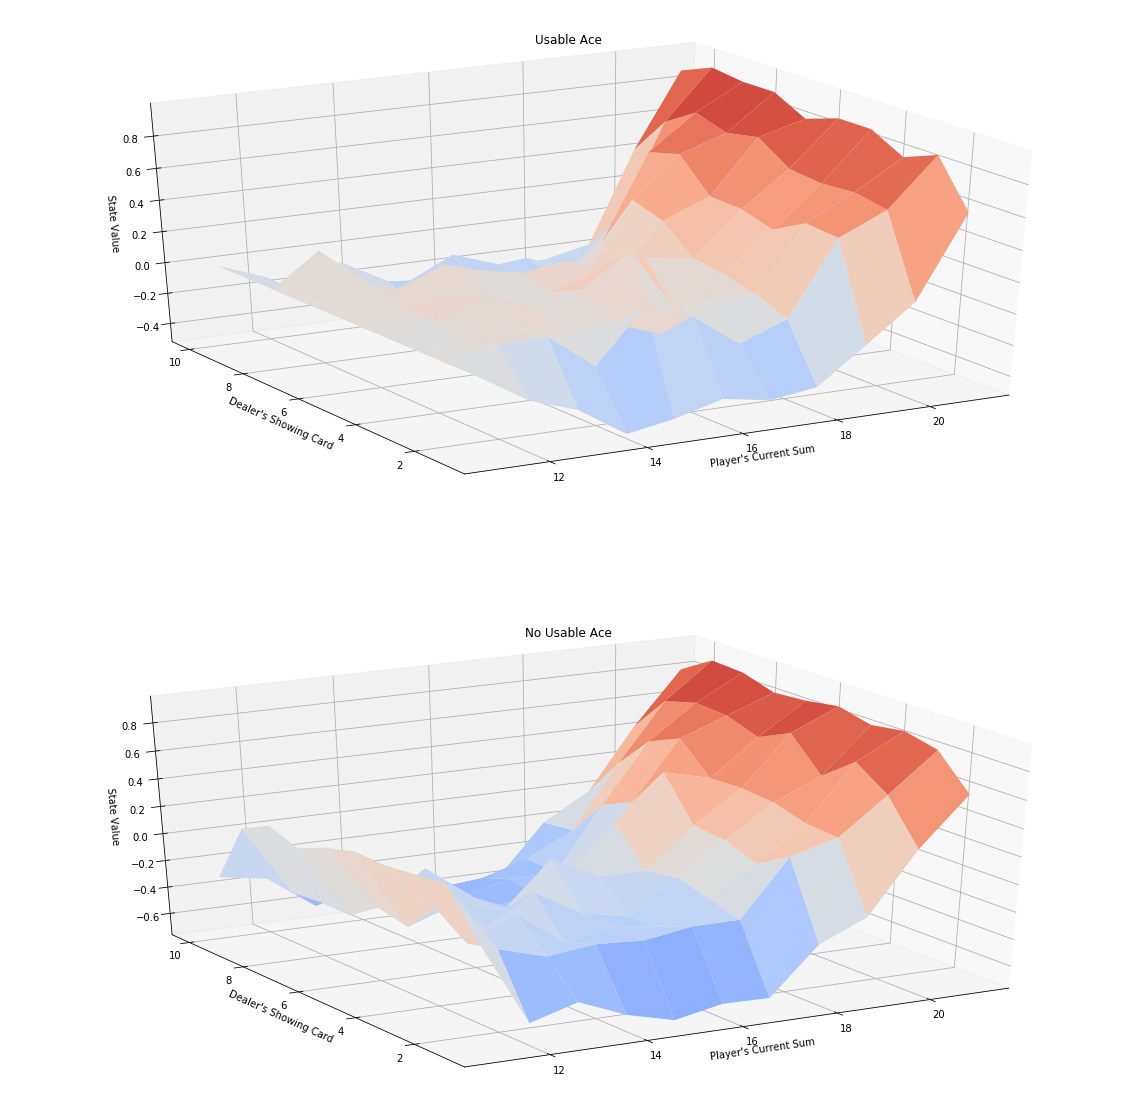

In [17]:
# obtain the corresponding state-value function
V = dict((k, np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

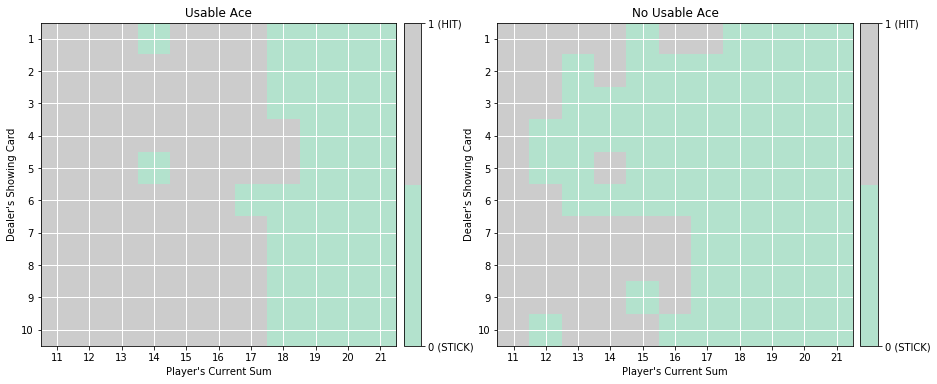

In [18]:
# plot the optimal policy
plot_policy(optimal_policy)

## Time To Play!

In [19]:
num_episodes=1000
score = evaluate_policy(env, optimal_policy, num_episodes=num_episodes)
print(f'Policy Score: {score} (Wins {int(score * num_episodes)} of {num_episodes})')

Now, the agent is playing...
Policy Score: 0.42 (Wins 420 of 1000)


---